In [1]:
!pip3 install --upgrade tables
!pip3 install python_speech_features
from google.colab import drive
drive.mount('/content/drive')

Requirement already up-to-date: tables in /usr/local/lib/python3.6/dist-packages (3.5.2)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
from python_speech_features import mfcc
from python_speech_features import logfbank
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import decimate
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from keras.utils import to_categorical
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, Bidirectional
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics
from sklearn.utils import class_weight
from datetime import datetime
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2, l1
import librosa, librosa.display
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

%matplotlib inline

Using TensorFlow backend.


## Loading Data
### Loading the dataframe containing sound files arrays 

In [0]:
df = pd.read_hdf('/content/drive/My Drive/DataSet/all_final.h5', 'raw')

### Number of examples per class

In [6]:
df.groupby('label').count()['length']

label
artifact__              40
extrahls__              19
extrastole__            46
murmur__               100
murmur_noisymurmur_     29
normal__               231
normal_noisynormal_    120
Name: length, dtype: int64

### Since noisy data is considered as a subtype, their labels are changed to the parent label

In [4]:
#labeling "noisy" as normal
df.loc[df['label'] == 'murmur_noisymurmur_', 'label'] = 'murmur__'
df.loc[df['label'] == 'normal_noisynormal_', 'label'] = 'normal__'

#thus the new distribution
df.groupby('label').count()

,audio,sampling_rate,length
label,,,
artifact__,40,40,40
extrahls__,19,19,19
extrastole__,46,46,46
murmur__,129,129,129
normal__,351,351,351


It's evident that there is a high imblance in the dataset. This will adressed later.

## Helper Functions
Since all the instances aren't equal in length, they are split into 4 second instances. The functions below are used for this purpose.



In [5]:
#funtion for repeating
#adding param rep_from, should be the same as the original array in most cases
def repeat_to_length(arr, length):
    result = np.empty((length, ), dtype = 'float32')
    l = len(arr)
    pos = 0
    result[pos:pos+l] = arr
    
    #chaning now to ref
    pos += l
    l = len(arr)
    
    while pos + l <= length:
        result[pos:pos+l] = arr
        pos += l
    if pos < length:
        result[pos:length] = arr[:length-pos]
    return result

'''
#function for windowing (splitting)
#not going with the extend and divide approach so as to enable hopping
def get_windows(audio, win_length = 100000, hop = 100000/2, method = 'pad', sr = 22050):
  #converting to int to use as slice indices
  win_length = int(win_length)
  hop = int(hop)

  windows = []
  end = win_length
	
  #gets windows untill the end of audio is surpassed
  while end <= len(audio):
    windows.append(
        audio[end - win_length : end]
    ) 
    end += hop

  #gets the last frame if length of remaining portion is greater than sr/10 (1/50 of a second)
  if ((end - hop) < len(audio) and (len(audio) - (end - hop) > int(sr/50))) or len(windows) == 0:
    if method == 'pad':
      windows.append(pad(audio[end - win_length : len(audio)], win_length))
    elif method == 'rep':
      windows.append(repeat_to_length(audio[end - win_length : len(audio)], audio, win_length))

  return windows
'''

"\n#function for windowing (splitting)\n#not going with the extend and divide approach so as to enable hopping\ndef get_windows(audio, win_length = 100000, hop = 100000/2, method = 'pad', sr = 22050):\n  #converting to int to use as slice indices\n  win_length = int(win_length)\n  hop = int(hop)\n\n  windows = []\n  end = win_length\n\t\n  #gets windows untill the end of audio is surpassed\n  while end <= len(audio):\n    windows.append(\n        audio[end - win_length : end]\n    ) \n    end += hop\n\n  #gets the last frame if length of remaining portion is greater than sr/10 (1/50 of a second)\n  if ((end - hop) < len(audio) and (len(audio) - (end - hop) > int(sr/50))) or len(windows) == 0:\n    if method == 'pad':\n      windows.append(pad(audio[end - win_length : len(audio)], win_length))\n    elif method == 'rep':\n      windows.append(repeat_to_length(audio[end - win_length : len(audio)], audio, win_length))\n\n  return windows\n"

Transforming data into required 4 second cuts

585it [00:00, 3653.26it/s]


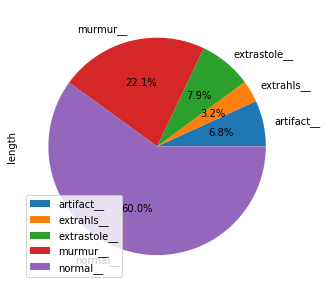

In [6]:
MAX_LEN = 22050 * 6  #4 seconds

data = []

for row in tqdm(df.iterrows()):
  if len(row[1]['audio']) < MAX_LEN:
    audio = repeat_to_length(row[1]['audio'], MAX_LEN)
  else:
    audio = row[1]['audio'][:MAX_LEN]                                                
  
  data.append([audio, row[1]['sampling_rate'], len(audio), row[1]['label']])

df = pd.DataFrame(data, columns = ['audio', 'sampling_rate', 'length', 'label'])

dist = df.groupby('label').count()

#plotting the final distribution
dist.plot.pie(y='length', figsize=(5, 5), autopct='%1.1f%%')

It's evident that there is a high imblance in the dataset. This will adressed later.

## Pre-Processing the Data
The audio signals are in the time domain which represents the changes in the amplitude with respect to time.

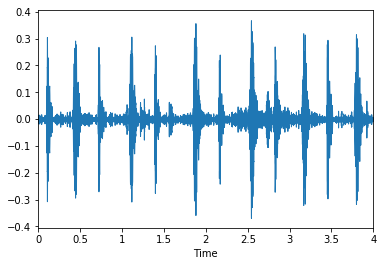

In [19]:
signal = df.loc[100]['audio']
label = df.loc[100]['label']
sampling_rate = df.loc[100]['sampling_rate']

librosa.display.waveplot(signal, sr=sampling_rate)

### Short Time Fourier Transform
The signal can be transformed into the frequency domain representation via Short Time Fourier Transform (STFT). STFT is obtained by segmenting a signal into frames of a few millisconds. Since the frame size is a very short time period, it is safe to assume that the signal is stationary within the frame. Direct Fourier Transform is then applied to them, thereby transforming the frames into the frequency domain. Thus the magnitude of various frequencies present in each frame at different points in time is obtained. 

The following video provides a good explaination of the process: https://youtu.be/g1_wcbGUcDY

Librosa provides a function to obtain the short time fourier transform of a signal.

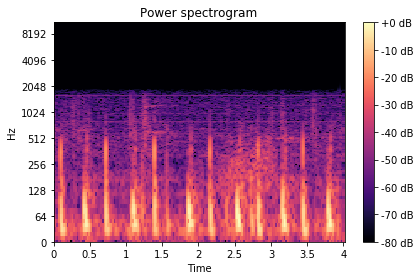

In [22]:
D = np.abs(librosa.stft(signal))
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

### Filter Banks
The ability of human hearing to tell apart two frequencies is non-linear. It's easier to distinguish lower frequencies than it is to distinguish higher frequencies. The Mel-Scale models this phenomenon.
The Filter Banks used here are group of triangular filters used on the generated STFT. Thus the frequecies are grouped into different bins. The spacing between the filters vary according to the Mel-Scale. 
This can be represented as:
![alt text](https://haythamfayek.com/assets/posts/post1/mel_filters.jpg)
Source: https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

At lower frequency ranges the filters are closer and capture more details than the ones at the higher frequency ranges.

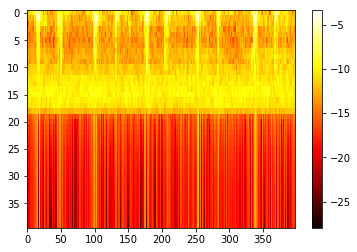

In [29]:
bank = logfbank(audio, sampling_rate, nfilt=40, nfft=int(0.025 * 22050)).T
plt.imshow(bank, cmap = 'hot', interpolation = 'nearest', aspect = 'auto')
plt.colorbar()

plt.show()

## Creating Filter Banks from audio data

In [7]:
#list to store data
X= []
Y = []

for row in tqdm(df.iterrows()):
  bank = logfbank(row[1]['audio'], 22050, nfilt=26, nfft=int(0.025 * 22050))
  X.append(bank)
  Y.append(row[1]['label'])

X = np.array(X)
Y = np.array(Y)

585it [00:22, 25.28it/s]


Following line of code handles class imbalance

In [0]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(Y), Y)

### Splitting data into Train and Test sets

In [9]:
le = LabelEncoder()
Y2 = to_categorical(le.fit_transform(Y))

print(X.shape, Y.shape)

x_train, x_test, y_train, y_test = train_test_split(X, Y2, test_size=0.2, random_state = 42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(585, 598, 26) (585,)
(468, 598, 26) (468, 5)
(117, 598, 26) (117, 5)


## Finally, the model to classify the data!
Audio data is inherently sequential in nature. An architecture with **LSTM**s thus performs well given the ability of LSTMs to capture patterns that occur over long periods of time.

In [10]:
model = Sequential()

model.add(LSTM(32, return_sequences = True, input_shape = x_train.shape[1:])) #reducing from 128 to 80
model.add(Dropout(0.3))

model.add(LSTM(32, return_sequences = True, input_shape = x_train.shape[1:])) #reducing from 128 to 80
model.add(Dropout(0.3))

model.add(Dense(64, activation = 'relu', kernel_regularizer = l2(0.08), bias_regularizer = l2(0.08)))  #128 to 100
model.add(Dropout(0.4))

model.add(Dense(64, activation = 'relu', kernel_regularizer = l2(0.08), bias_regularizer = l2(0.08)))  #128 to 100
model.add(Dropout(0.4))

model.add(Dense(64, activation = 'relu', kernel_regularizer = l2(0.1), bias_regularizer = l2(0.1)))  #128 to 100 --CHANGED FROM 128
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(5, activation = 'softmax')) #output classes

model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 598, 32)           7552      
_________________________________________________________________
dropout_1 (Dropout)          (None, 598, 32)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 598, 32)           8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 598, 32)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 598, 64)           2112      
_________________________________________________________________
dropout_3 (Dropout)          (None, 598, 64)           0         
_

In [11]:
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


mcp_save = ModelCheckpoint('/content/drive/My Drive/DataSet/final_weights.{epoch:02d}-{val_acc:.2f}.hdf5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                              patience=5, min_lr=0.001)
num_epochs = 800
num_batch_size = 128

start = datetime.now()
history = model.fit(
            x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, 
            validation_data=(x_test, y_test), verbose=1, shuffle = True, 
            class_weight=class_weights, callbacks = [mcp_save]
         )

duration = datetime.now() - start
print("Training completed in time: ", duration)

score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("training accuracy: %.4f%%" % accuracy)

#Epoch 717/1200
#468/468 [==============================] - 10s 22ms/step - loss: 0.7140 - acc: 0.8034 - val_loss: 0.8654 - val_acc: 0.7863
#reached 78.9 something. train again. should start around this
#Epoch 1/800
#468/468 [==============================] - 14s 30ms/step - loss: 16.4147 - acc: 0.4615 - val_loss: 16.1609 - val_acc: 0.5641



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 468 samples, validate on 117 samples
Epoch 1/800
468/468 [==============================] - 8s 18ms/step - loss: 16.3238 - acc: 0.4786 - val_loss: 16.2687 - val_acc: 0.5641

Epoch 00001: val_loss improved from inf to 16.26873, saving model to /content/drive/My Drive/DataSet/final_weights.01-0.56.hdf5
Epoch 2/800
468/468 [==============================] - 6s 13ms/step - loss: 16.0548 - acc: 0.6047 - val_loss: 16.1123 - val_acc: 0.5641

Epoch 00002: val_loss improved from 16.26873 to 16.11228, saving model to /content/drive/My Drive/DataSet/final_weights.02-0.56.hdf5
Epoch 3/800
468/468 [==============================] - 6s 14ms/step - loss: 15.9560 - acc: 0.6047 - val_loss: 15.9922 - val_acc: 0.5641

Epoch 00003: val_loss improved from 16.11228 to 15.99217, saving model to /content/drive/My Drive/DataSet/final_weights.03-0.56.hdf5
Epoch 4/800
468/468 [==============================] 

## Classification Results

In [0]:
#loading saved model
model = load_model('/content/drive/My Drive/DataSet/final_weights.785-0.78.hdf5')

In [30]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy: %2.2f' %(scores[1]*100))

117/117 [==============================] - 2s 18ms/step
Test loss: 0.8483517180141221
Test accuracy: 77.78


### Confusion Matrix

In [31]:
predictions = model.predict(x_test, verbose=1)
y_true, y_pred = [],[]
classes = le.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])

117/117 [==============================] - 2s 19ms/step


In [32]:
np.seterr(divide='ignore', invalid='ignore')
print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

  artifact__       1.00      0.89      0.94         9
  extrahls__       0.00      0.00      0.00         0
extrastole__       0.00      0.00      0.00         0
    murmur__       0.73      0.95      0.83        20
    normal__       0.97      0.73      0.83        88

    accuracy                           0.78       117
   macro avg       0.54      0.51      0.52       117
weighted avg       0.93      0.78      0.84       117



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
#loading saved model
model = load_model('/content/drive/My Drive/DataSet/final_weights.406-0.79.hdf5')

In [25]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy: %2.2f' %(scores[1]*100))

117/117 [==============================] - 2s 15ms/step
Test loss: 2.0961458132817197
Test accuracy: 79.49


In [26]:
print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

  artifact__       1.00      0.89      0.94         9
  extrahls__       0.00      0.00      0.00         0
extrastole__       0.00      0.00      0.00         0
    murmur__       0.73      0.95      0.83        20
    normal__       0.97      0.73      0.83        88

    accuracy                           0.78       117
   macro avg       0.54      0.51      0.52       117
weighted avg       0.93      0.78      0.84       117



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
